<a href="https://colab.research.google.com/github/suba0712200-oss/time-series-forecasting-attention/blob/main/Advanced_Time_Series_Forecasting_using_Deep_Learning_with_Attention_Mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# 1. IMPORT LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Attention
from tensorflow.keras.models import Model

np.random.seed(42)
tf.random.set_seed(42)

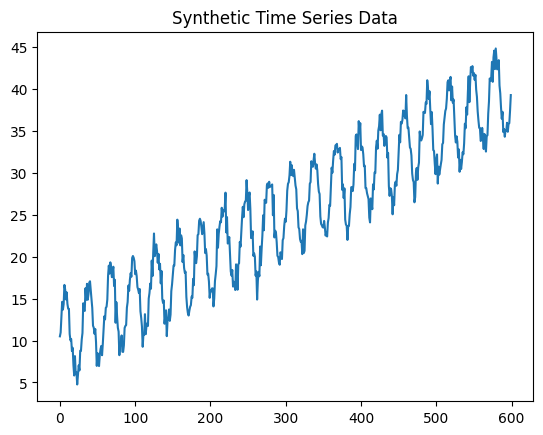

In [ ]:
# 2. DATA GENERATION:

t = np.arange(600)
data = 10 + 0.05*t + 5*np.sin(2*np.pi*t/30) + np.random.normal(0, 1, 600)
series = pd.Series(data)

plt.figure()
plt.plot(series)
plt.title("Synthetic Time Series Data")
plt.show()


In [ ]:
# 3. TRAIN - TEST SPLIT

train = series[:500]
test = series[500:]

In [ ]:
# 4. ARIMA MODEL (BASELINE)

arima_model = ARIMA(train, order=(2,1,2))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))

arima_mae = mean_absolute_error(test, arima_pred)
arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))

print("ARIMA MAE :", arima_mae)
print("ARIMA RMSE:", arima_rmse)


ARIMA MAE : 11.123474193554701
ARIMA RMSE: 11.894993607557423


In [ ]:
# 5. DATA PREP FOR LSTM

scaler = MinMaxScaler()
scaled = scaler.fit_transform(series.values.reshape(-1,1))

def create_sequences(data, window=10):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, window=10)

X_train, X_test = X[:500], X[500:]
y_train, y_test = y[:500], y[500:]


In [ ]:
# 6. LSTM + ATTENTION MODEL

inputs = Input(shape=(10,1))
lstm_out = LSTM(32, return_sequences=True)(inputs)
attn_out = Attention()([lstm_out, lstm_out])
output = Dense(1)(attn_out[:, -1, :])

model = Model(inputs, output)
model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 10, 32)    │      4,352 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ (None, 10, 32)    │          0 │ lstm_4[0][0],     │
│ (Attention)         │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 32)        │          0 │ attention_4[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         33 │ get_item_4[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1221
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0192
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0146
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0114
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0111
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0108
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0107
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0106
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0105
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0104


In [ ]:
# 7. LSTM PREDICTION & EVALUATION

lstm_pred = model.predict(X_test)

lstm_pred_inv = scaler.inverse_transform(lstm_pred)
y_test_inv = scaler.inverse_transform(y_test)

lstm_mae = mean_absolute_error(y_test_inv, lstm_pred_inv)
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_pred_inv))

print("LSTM + Attention MAE :", lstm_mae)
print("LSTM + Attention RMSE:", lstm_rmse)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
LSTM + Attention MAE : 3.614362747617799
LSTM + Attention RMSE: 4.204223578158719


In [ ]:
# 8. FINAL COMPARISON
results = pd.DataFrame({
    "Model": ["ARIMA", "LSTM + Attention"],
    "MAE": [arima_mae, lstm_mae],
    "RMSE": [arima_rmse, lstm_rmse]
})

print("\nFINAL RESULTS")
print(results)


FINAL RESULTS
              Model        MAE       RMSE
0             ARIMA  11.123474  11.894994
1  LSTM + Attention   3.614363   4.204224
